In [1]:
import sys
sys.path.append('../src')

import sqlite3
import typing as tp
from pathlib import Path

import pandas as pd
import cv2
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
from tqdm import tqdm
from omegaconf import OmegaConf
from skimage import measure

from measure_blur_strength import main
from metrics import ssim, psnr
from imutils import imsshow, load_npy, imread, srgb2gray, center_crop, imshow, impreprocess
from data.convolution import convolve
from data.convertation import srgbf_to_linrgbf, uint8_to_float32
from data.generate.gauss_blur import generate_gauss_kernel
from deconv.classic.wiener.wiener import wiener_gray
from deconv.neural.usrnet.predictor import USRNetPredictor

plt.gray()

<Figure size 640x480 with 0 Axes>

In [2]:
def pad_to_shape(a, shape):
    y_, x_ = shape
    y, x = a.shape
    y_pad = (y_-y)
    x_pad = (x_-x)
    return np.pad(a,((y_pad//2, y_pad//2 + y_pad%2), 
                     (x_pad//2, x_pad//2 + x_pad%2)), mode = 'constant')


def _1d_t0_3d(image: np.ndarray) -> np.ndarray:
    return np.dstack([image for _ in range(3)])

## 1 Эксперимент: Метрики между исходным и размытым изображениями

In [4]:
metrics = main(benchmark_list_path='datasets/full_dataset.txt')

1162it [05:46,  3.35it/s]


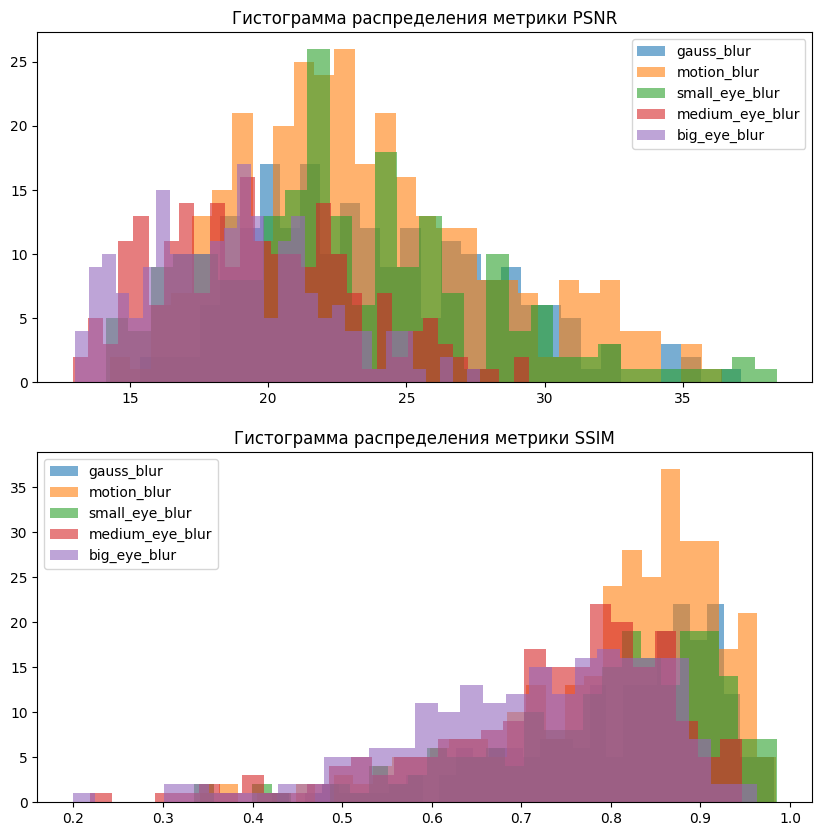

In [5]:
fig, axs = plt.subplots(2, 1, figsize=(10, 10))

for i, metric_name in zip(range(len(axs)), ['psnr', 'ssim']):
    for blur_type in metrics.keys():
        axs[i].hist(metrics[blur_type][metric_name], label=blur_type, bins=30, alpha=0.6)
    axs[i].legend()
    axs[i].set_title(f'Гистограмма распределения метрики {metric_name.upper()}')

Средние и СКО:

In [6]:
for blur_type in metrics.keys():
    print(blur_type)

    psnr_stats = stats.describe(metrics[blur_type]['psnr'])
    print(f'psnr | mean / std: {psnr_stats.mean:.4f} / {psnr_stats.variance ** 0.5:.4f}; min-max: {psnr_stats.minmax}')

    ssim_stats = stats.describe(metrics[blur_type]['ssim'])
    print(f'ssim | mean / std: {ssim_stats.mean:.4f} / {ssim_stats.variance ** 0.5:.4f}; min-max: {ssim_stats.minmax}')
    print()

gauss_blur
psnr | mean / std: 23.9129 / 4.3690; min-max: (15.364728523229632, 37.10979814092341)
ssim | mean / std: 0.8129 / 0.1146; min-max: (0.42166785784952154, 0.9818222732056389)

motion_blur
psnr | mean / std: 23.5747 / 4.5509; min-max: (14.287301023369869, 36.41456360353609)
ssim | mean / std: 0.8056 / 0.1220; min-max: (0.34092253034761233, 0.9845391364219598)

small_eye_blur
psnr | mean / std: 22.8789 / 4.8939; min-max: (14.144223258508813, 38.40715738726519)
ssim | mean / std: 0.7947 / 0.1294; min-max: (0.3347042621553864, 0.985602278528804)

medium_eye_blur
psnr | mean / std: 19.5776 / 3.5359; min-max: (12.931258779844034, 29.44787874531591)
ssim | mean / std: 0.7317 / 0.1382; min-max: (0.21857764551226777, 0.9460094472515295)

big_eye_blur
psnr | mean / std: 18.6399 / 3.1154; min-max: (13.03422491749159, 27.667130206851553)
ssim | mean / std: 0.7114 / 0.1393; min-max: (0.19903014622408063, 0.9632875505871187)



Тест Манна-Уитни о равенстве мат.ожидания выборочному среднему:

In [7]:
print('gauss_blur')
print(stats.mannwhitneyu(metrics['gauss_blur']['psnr'], 23.9))
print(stats.mannwhitneyu(metrics['gauss_blur']['ssim'], 0.81))
print()

print('motion_blur')
print(stats.mannwhitneyu(metrics['motion_blur']['psnr'], 23.6))
print(stats.mannwhitneyu(metrics['motion_blur']['ssim'], 0.81))
print()

print('small_eye_blur')
print(stats.mannwhitneyu(metrics['small_eye_blur']['psnr'], 22.9))
print(stats.mannwhitneyu(metrics['small_eye_blur']['ssim'], 0.79))
print()

print('medium_eye_blur')
print(stats.mannwhitneyu(metrics['medium_eye_blur']['psnr'], 19.6))
print(stats.mannwhitneyu(metrics['medium_eye_blur']['ssim'],  0.73))
print()

print('big_eye_blur')
print(stats.mannwhitneyu(metrics['big_eye_blur']['psnr'], 18.6))
print(stats.mannwhitneyu(metrics['big_eye_blur']['ssim'], 0.71))
print()

gauss_blur
MannwhitneyuResult(statistic=93.0, pvalue=0.8909952606635061)
MannwhitneyuResult(statistic=131.0, pvalue=0.7582938388625584)

motion_blur
MannwhitneyuResult(statistic=138.0, pvalue=0.8606811145510818)
MannwhitneyuResult(statistic=197.0, pvalue=0.7801857585139306)

small_eye_blur
MannwhitneyuResult(statistic=93.0, pvalue=0.8909952606635061)
MannwhitneyuResult(statistic=129.0, pvalue=0.7772511848341224)

medium_eye_blur
MannwhitneyuResult(statistic=98.0, pvalue=0.938388625592416)
MannwhitneyuResult(statistic=125.0, pvalue=0.8151658767772503)

big_eye_blur
MannwhitneyuResult(statistic=106.0, pvalue=0.9952606635071078)
MannwhitneyuResult(statistic=119.0, pvalue=0.8720379146919421)



Проверка на нормальный ЗР:

In [8]:
for blur_type in metrics.keys():
    print(blur_type)

    t_statistic, p_value = stats.shapiro(metrics[blur_type]['psnr'])
    print(f'psnr | t_statistic: {t_statistic:.4f}, p-value: {p_value:.4f}')

    t_statistic, p_value = stats.shapiro(metrics[blur_type]['ssim'])
    print(f'ssim | t_statistic: {t_statistic:.4f}, p-value: {p_value:.4f}')

    print()

gauss_blur
psnr | t_statistic: 0.9703, p-value: 0.0002
ssim | t_statistic: 0.9126, p-value: 0.0000

motion_blur
psnr | t_statistic: 0.9697, p-value: 0.0000
ssim | t_statistic: 0.9039, p-value: 0.0000

small_eye_blur
psnr | t_statistic: 0.9680, p-value: 0.0001
ssim | t_statistic: 0.9232, p-value: 0.0000

medium_eye_blur
psnr | t_statistic: 0.9792, p-value: 0.0034
ssim | t_statistic: 0.9221, p-value: 0.0000

big_eye_blur
psnr | t_statistic: 0.9802, p-value: 0.0047
ssim | t_statistic: 0.9523, p-value: 0.0000



### Визуализация

In [9]:
image_path = 'datasets/gt/precomp/texts/_10_1.jpg'

image = imread(image_path)

if image_path.endswith('.jpg'):  # sRGB 8 bit
    image = uint8_to_float32(image)  # sRGB float

if image.ndim == 3:
    image = srgb2gray(image)  # sRGB float

image = srgbf_to_linrgbf(image)  # linRGB float


In [10]:
kernels = {
    'gauss_blur': load_npy('datasets/kernels/gauss-blur/processed/synthetic/synthetic-0.npy', key='psf'),
    'motion_blur': load_npy('datasets/kernels/motion-blur/processed/synthetic/synthetic-16.npy', key='psf'),
    'small_eye_blur': load_npy('datasets/kernels/eye-psf/processed/synthetic/small-psf-0.npy', key='psf'),
    'medium_eye_blur': load_npy('datasets/kernels/eye-psf/processed/synthetic/medium-psf-0.npy', key='psf'),
    'big_eye_blur': load_npy('datasets/kernels/eye-psf/processed/synthetic/big-psf-0.npy', key='psf'),
}

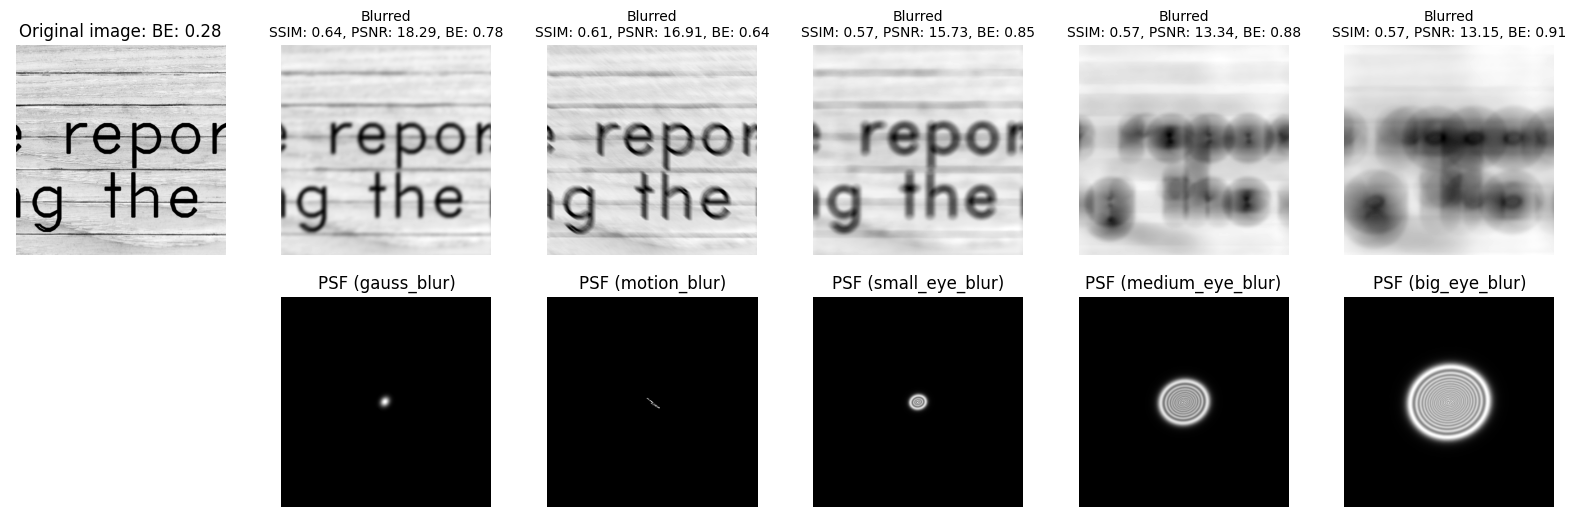

In [11]:
fig, axs = plt.subplots(2, 6, figsize=(20, 6))

[axi.set_axis_off() for axi in axs.ravel()]

axs[0, 0].imshow(image)
axs[0, 0].set_title(f'Original image: BE: {measure.blur_effect(image):.2f}')

for i, (kernel_type, kernel) in enumerate(kernels.items()):
    blurred = convolve(image, kernel).astype(np.float32)
    axs[0, i + 1].imshow(blurred)
    axs[0, i + 1].set_title(f'Blurred\nSSIM: {ssim(image, blurred):.2f}, PSNR: {psnr(image, blurred):.2f}, BE: {measure.blur_effect(blurred):.2f}', fontsize=10)
    axs[1, i + 1].imshow(pad_to_shape(kernel, (256, 256)))
    axs[1, i + 1].set_title(f'PSF ({kernel_type})')

Увеличение площади контура PSF

Гаусс

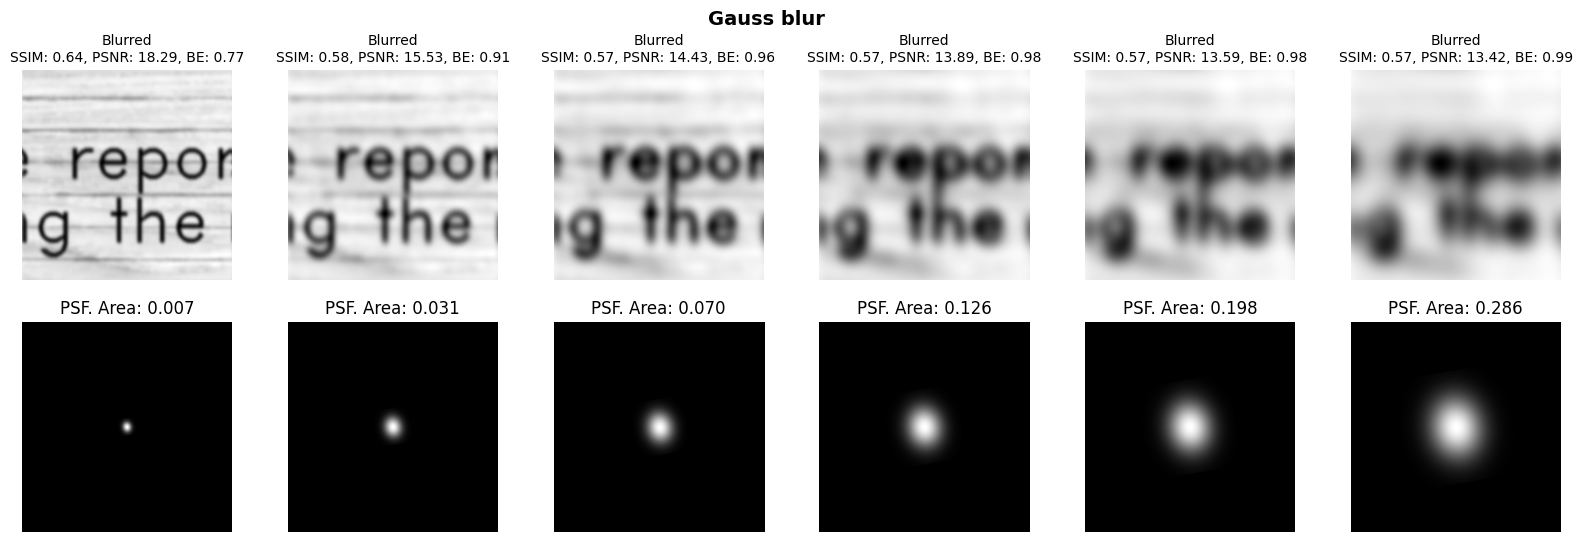

In [12]:
fig, axs = plt.subplots(2, 6, figsize=(20, 6))
fig.suptitle('Gauss blur', fontsize=14, fontweight='black')

[axi.set_axis_off() for axi in axs.ravel()]

for i in range(1, 7):
    psf = generate_gauss_kernel(sigmax=6 * i, sigmay=5 * i, size=(3, 3), angle=10)

    blurred = convolve(image, psf).astype(np.float32)
    axs[0, i-1].imshow(blurred)
    axs[0, i-1].set_title(f'Blurred\nSSIM: {ssim(image, blurred):.2f}, PSNR: {psnr(image, blurred):.2f}, BE: {measure.blur_effect(blurred):.2f}', fontsize=10)

    if psf.shape[0] < 256 and psf.shape[1] < 256:
        psf = pad_to_shape(psf, (256, 256))
    axs[1, i-1].imshow(pad_to_shape(psf, (256, 256)))
    axs[1, i-1].set_title(f'PSF. Area: {len(psf[psf > 0]) / len(psf.ravel()):.3f}')

Motion blur

In [13]:
kernel = load_npy('datasets/kernels/motion-blur/processed/Levin/levin-0.npy', key='psf')
kernel.shape

(19, 19)

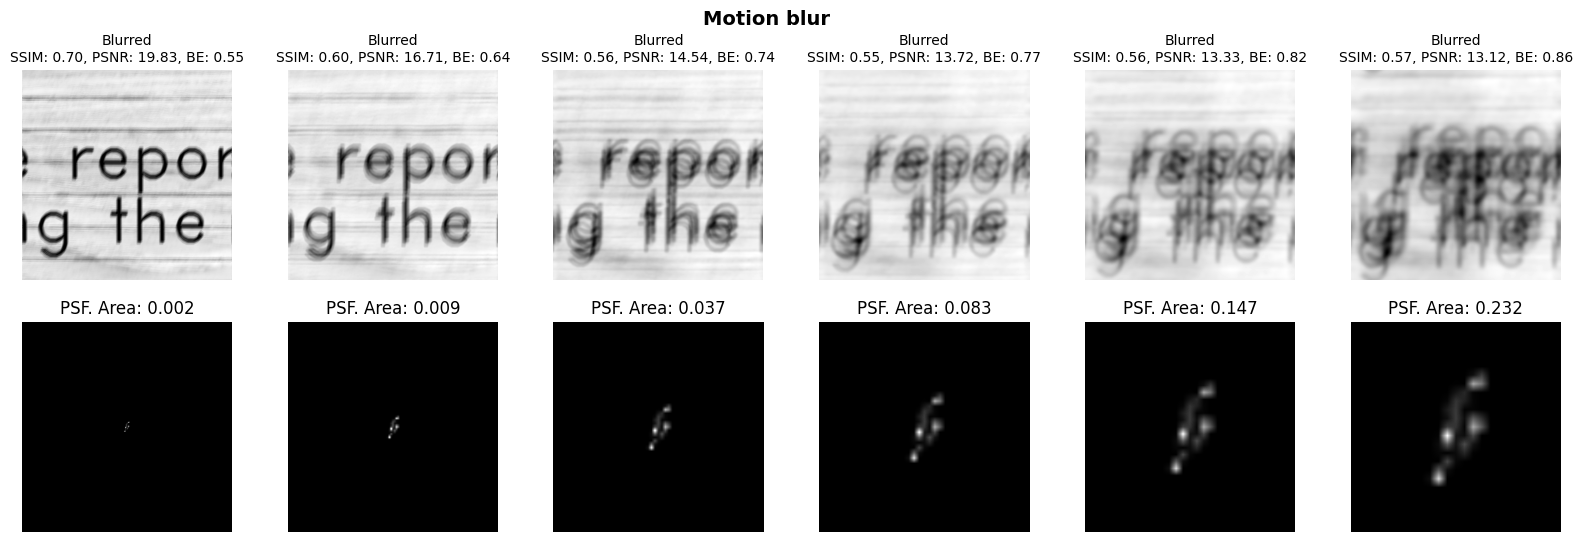

In [14]:
fig, axs = plt.subplots(2, 6, figsize=(20, 6))
[axi.set_axis_off() for axi in axs.ravel()]
fig.suptitle('Motion blur', fontsize=14, fontweight='black')

for i in range(6):
    if i == 0:
        psf = kernel.copy()
    else:
        psf = cv2.resize(kernel, (40 * i, 40 * i))
        psf = psf / psf.sum()
    
    blurred = convolve(image, psf).astype(np.float32)
    axs[0, i].imshow(blurred)
    axs[0, i].set_title(f'Blurred\nSSIM: {ssim(image, blurred):.2f}, PSNR: {psnr(image, blurred):.2f}, BE: {measure.blur_effect(blurred):.2f}', fontsize=10)

    if psf.shape[0] < 256 and psf.shape[1] < 256:
        psf = pad_to_shape(psf, (256, 256))
    axs[1, i].imshow(pad_to_shape(psf, (256, 256)))
    axs[1, i].set_title(f'PSF. Area: {len(psf[psf > 0]) / len(psf.ravel()):.3f}')

### Зависимость силы размытия от размера ядра

In [15]:
def generate_samples(image: np.ndarray, kernels_dir: str, num_kernels: int, num_iter: int = 11) -> tp.Tuple[tp.List[int], tp.List[float], tp.List[float]]:
    psfs = list(Path(kernels_dir).rglob('*.npy'))
    psfs = [load_npy(psf_path, key='psf') for psf_path in psfs[:num_kernels]]

    kernel_sizes = []
    psnrs = []
    ssims = []

    for kernel in tqdm(psfs):
        for i in range(num_iter):
            if i == 0:
                psf = kernel.copy()
                kernel_size = psf.shape[0]
            else:
                kernel_size = kernel.shape[0] + 20 * i
                psf = cv2.resize(kernel, (kernel_size, kernel_size))
                psf = psf / psf.sum()
            
            blurred = convolve(image, psf).astype(np.float32)
            psnrs.append(psnr(image, blurred))
            ssims.append(ssim(image, blurred))
            kernel_sizes.append(kernel_size)
    return kernel_sizes, psnrs, ssims

In [18]:
motion_kernel_sizes, motion_psnrs, motion_ssims = generate_samples(image, 'datasets/kernels/motion-blur/processed/Levin/', 8, num_iter=12)
gauss_kernel_sizes, gauss_psnrs, gauss_ssims = generate_samples(image, 'datasets/kernels/gauss-blur/processed/synthetic/', 8, num_iter=11)

100%|██████████| 8/8 [00:01<00:00,  4.48it/s]


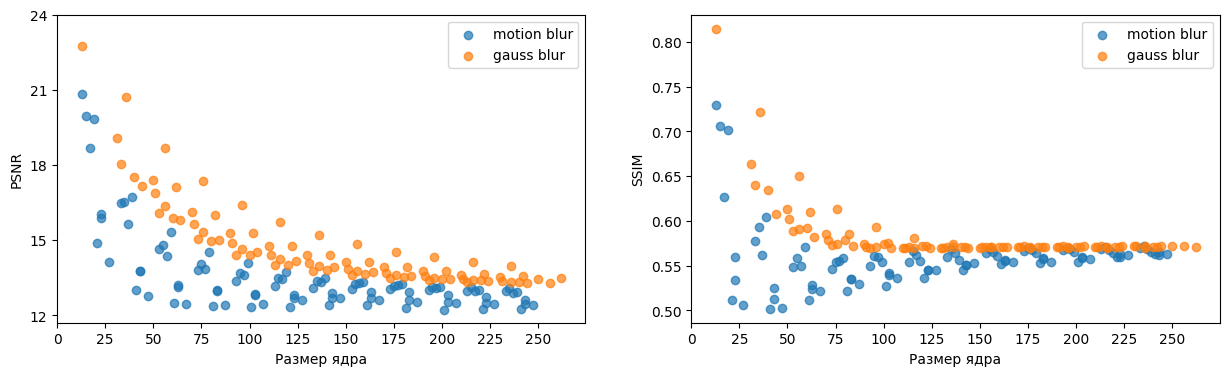

In [19]:
fig, axs = plt.subplots(1, 2, figsize=(15, 4))

axs[0].scatter(motion_kernel_sizes, motion_psnrs, alpha=0.7, label='motion blur')
axs[0].scatter(gauss_kernel_sizes, gauss_psnrs, alpha=0.7, label='gauss blur')
axs[0].set_xlabel('Размер ядра')
axs[0].set_xticks(np.arange(0, 251, 25))
axs[0].set_yticks(np.arange(12, 25, 3))
axs[0].set_ylabel('PSNR')
axs[0].legend()

axs[1].scatter(motion_kernel_sizes, motion_ssims, alpha=0.7, label='motion blur')
axs[1].scatter(gauss_kernel_sizes, gauss_ssims, alpha=0.7, label='gauss blur')
axs[1].set_xlabel('Размер ядра')
axs[1].set_xticks(np.arange(0, 251, 25))
axs[1].set_ylabel('SSIM')
axs[1].legend()


## 2 Эксперимент: Метрики Винеровского фильтра и USRNet

In [3]:
%load_ext sql

In [4]:
%sql sqlite:////nbdb/results/metrics.db

#### Метрики на linrgb float

In [5]:
conn = sqlite3.connect('/nbdb/results/metrics.db')

result_set = pd.read_sql_query(
'''
SELECT model,
       CASE
         WHEN kernel LIKE '%big%' THEN blur_type || '_big'
         WHEN kernel LIKE '%medium%' THEN blur_type || '_medium'
         WHEN kernel LIKE '%small%' THEN blur_type || '_small'
         ELSE blur_type
       END AS blur_type_detailed,
       ROUND(MIN(psnr), 4) AS 'min(PSNR)', 
       ROUND(AVG(psnr), 4) AS avg_PSNR, 
       ROUND(MAX(psnr), 4) AS 'max(PSNR)',
       ROUND(MIN(ssim), 4) AS 'min(SSIM)', 
       ROUND(AVG(ssim), 4) AS 'avg_SSIM', 
       ROUND(MAX(ssim), 4) AS 'max(SSIM)'
FROM main_FULL_16_05_v2
WHERE discretization == 'linrgb_float' AND noised == False AND model in ('usrnet', 'wiener_nonblind_noise') 
GROUP BY model, blur_type_detailed;
''', conn)

result_set


,model,blur_type_detailed,min(PSNR),avg_PSNR,max(PSNR),min(SSIM),avg_SSIM,max(SSIM)
0,usrnet,eye_blur_big,16.9607,29.3483,44.2905,0.5240,0.9024,0.9951
1,usrnet,eye_blur_medium,16.2887,31.5048,46.2366,0.4594,0.9228,0.9979
2,usrnet,eye_blur_small,23.6958,36.1651,46.9870,0.7820,0.9712,0.9993
3,usrnet,gauss_blur,17.6489,33.0687,43.9400,0.5773,0.9440,0.9991
4,usrnet,motion_blur,37.1434,45.4974,53.1374,0.9838,0.9963,0.9999
5,wiener_nonblind_noise,eye_blur_big,23.0643,33.8791,52.1668,0.8754,0.9714,0.9991
6,wiener_nonblind_noise,eye_blur_medium,24.0514,39.8022,60.0475,0.9054,0.9859,0.9998
7,wiener_nonblind_noise,eye_blur_small,33.5086,54.2357,85.0566,0.9783,0.9978,1.0000
8,wiener_nonblind_noise,gauss_blur,30.8845,44.4695,65.0845,0.9469,0.9934,1.0000
9,wiener_nonblind_noise,motion_blur,62.6996,84.9958,119.7820,0.9999,1.0000,1.0000


In [6]:
conn = sqlite3.connect('/nbdb/results/metrics.db')

result_set = pd.read_sql_query(
'''
SELECT model,
       CASE
         WHEN kernel LIKE '%big%' THEN blur_type || '_big'
         WHEN kernel LIKE '%medium%' THEN blur_type || '_medium'
         WHEN kernel LIKE '%small%' THEN blur_type || '_small'
         ELSE blur_type
       END AS blur_type_detailed,
       psnr,
       ssim
FROM main_FULL_16_05_v2
WHERE discretization == 'linrgb_float' AND noised == False AND model in ('usrnet', 'wiener_nonblind_noise');
''', conn)

result_set.head()

,model,blur_type_detailed,psnr,ssim
0,wiener_nonblind_noise,eye_blur_medium,39.564175,0.990652
1,usrnet,eye_blur_medium,27.889889,0.905310
2,wiener_nonblind_noise,eye_blur_medium,46.004995,0.997192
3,usrnet,eye_blur_medium,33.709235,0.954677
4,wiener_nonblind_noise,eye_blur_medium,43.296040,0.995785


In [7]:
def set_medians(data, ax, medians):
    pos = range(1, len(data)+1)
    for tick, label in zip(pos, ax.get_xticklabels()):
        ax.text(pos[tick-1], medians[tick-1], str(medians[tick-1]), 
                horizontalalignment='center', size='small', color='black', weight='semibold')

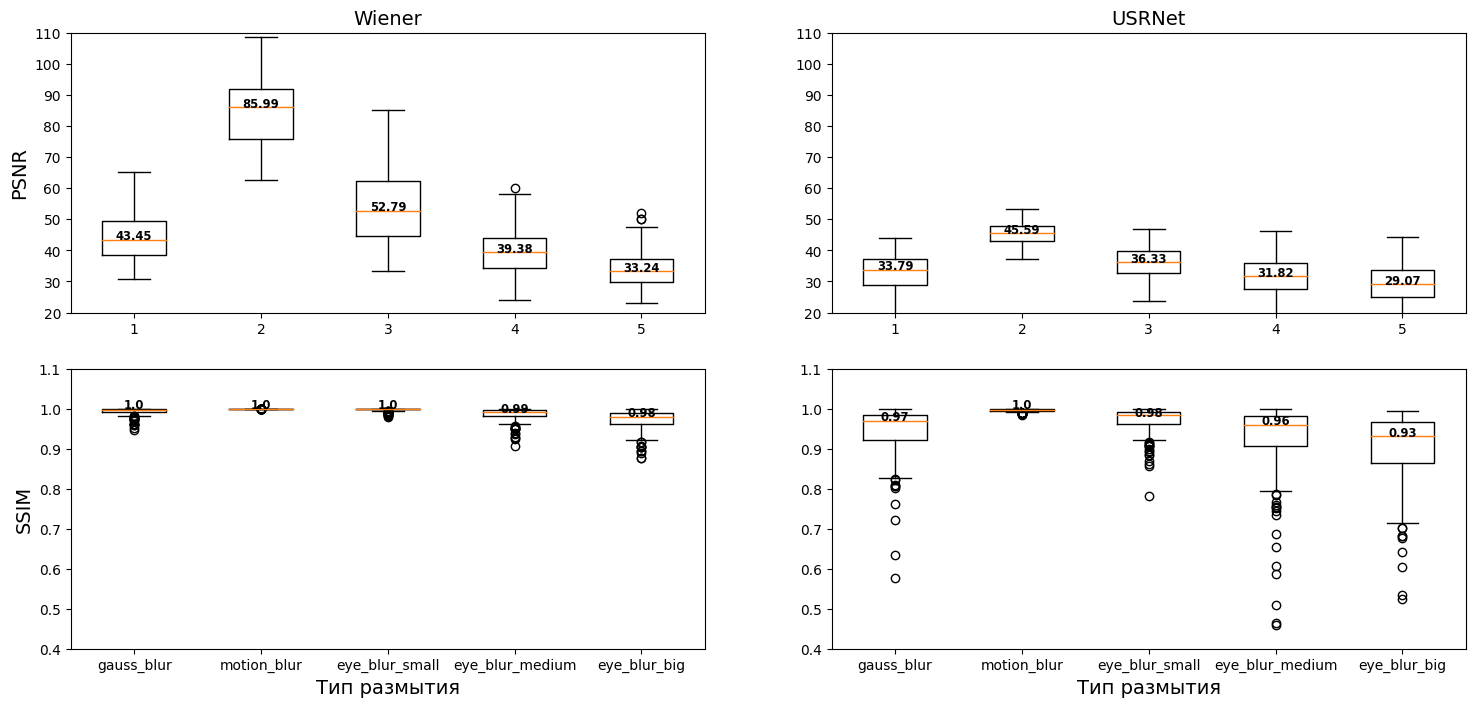

In [8]:
FONTSIZE=14
blur_types = ['gauss_blur', 'motion_blur', 'eye_blur_small', 'eye_blur_medium', 'eye_blur_big']

fig, axs = plt.subplots(2, 2, figsize=(18, 8))

data = [result_set[(result_set['model'] == 'wiener_nonblind_noise') & (result_set['blur_type_detailed'] == blur_type)]['psnr'] for blur_type in blur_types]
medians = [np.round(np.median(d), 2) for d in data]
axs[0, 0].boxplot(data)
axs[0, 0].set_ylabel("PSNR", fontsize=FONTSIZE)
axs[0, 0].set_title('Wiener', fontsize=FONTSIZE)
axs[0, 0].set_ylim(20, 110)
set_medians(data, axs[0, 0], medians)


data = [result_set[(result_set['model'] == 'usrnet') & (result_set['blur_type_detailed'] == blur_type)]['psnr'] for blur_type in blur_types]
medians = [np.round(np.median(d), 2) for d in data]
axs[0, 1].boxplot(data)
axs[0, 1].set_title('USRNet', fontsize=FONTSIZE)
axs[0, 1].set_ylim(20, 110)
set_medians(data, axs[0, 1], medians)


data = [result_set[(result_set['model'] == 'wiener_nonblind_noise') & (result_set['blur_type_detailed'] == blur_type)]['ssim'] for blur_type in blur_types]
medians = [np.round(np.median(d), 2) for d in data]
axs[1, 0].boxplot(data)
axs[1, 0].set_xticks([i for i in range(1, 6)], blur_types)
axs[1, 0].set_xlabel("Тип размытия", fontsize=FONTSIZE)
axs[1, 0].set_ylabel("SSIM", fontsize=FONTSIZE)
axs[1, 0].set_ylim(0.4, 1.1)
set_medians(data, axs[1, 0], medians)

data = [result_set[(result_set['model'] == 'usrnet') & (result_set['blur_type_detailed'] == blur_type)]['ssim'] for blur_type in blur_types]
medians = [np.round(np.median(d), 2) for d in data]
axs[1, 1].boxplot(data)
axs[1, 1].set_xticks([i for i in range(1, 6)], blur_types)
axs[1, 1].set_xlabel("Тип размытия", fontsize=FONTSIZE)
axs[1, 1].set_ylim(0.4, 1.1)
set_medians(data, axs[1, 1], medians)


In [9]:
def _1d_t0_3d(image: np.ndarray) -> np.ndarray:
    return np.dstack([image for _ in range(3)])


def viz(image_path: str, kernel_path: str, wiener: tp.Callable, usrnet: tp.Callable, blur_type: str):
    image = imread(image_path)
    image = center_crop(image, 256, 256)

    if image_path.endswith('.jpg'):  # sRGB 8 bit
        image = uint8_to_float32(image)  # sRGB float

    if image.ndim == 3:
        image = srgb2gray(image)  # sRGB float

    image = srgbf_to_linrgbf(image)  # linRGB float
    image_3d = _1d_t0_3d(image)

    psf = load_npy(kernel_path, key='psf')

    blurred = convolve(image, psf)
    blurred_3d = convolve(image_3d, psf)
    
    restored_wiener = wiener(blurred, psf)
    restored_usrnet = usrnet(blurred_3d, psf)

    fig, axs = plt.subplots(1, 5, figsize=(15, 4))
    [axi.set_axis_off() for axi in axs.ravel()]
    axs[0].imshow(pad_to_shape(psf, (256, 256)))
    axs[0].set_title(f'PSF ({blur_type})')

    axs[1].imshow(image_3d)
    axs[1].set_title('Original image')

    axs[2].imshow(blurred_3d)
    axs[2].set_title('Blurred')

    axs[3].imshow(restored_wiener)
    axs[3].set_title(f'Restored (Wiener)\nSSIM: {ssim(image, restored_wiener):.2f}, PSNR: {psnr(image, restored_wiener):.2f}')

    axs[4].imshow(restored_usrnet)
    axs[4].set_title(f'Restored (USRNet)\nSSIM: {ssim(image_3d, restored_usrnet, channel_axis=2):.2f}, PSNR: {psnr(image_3d, restored_usrnet):.2f}')

In [10]:
config = OmegaConf.load('../configs/config_viz_cuda.yml')
cm = config.models

wiener = lambda image, psf: wiener_gray(image, psf, balance=1e-8, clip=True)
usrnet = USRNetPredictor(model_path=cm.usrnet.model_path, **cm.usrnet.no_noise_params)

../src/deconv/neural/usrnet/model/model.py:142: UserWarning: The function torch.rfft is deprecated and will be removed in a future PyTorch release. Use the new torch.fft module functions, instead, by importing torch.fft and calling torch.fft.fft or torch.fft.rfft. (Triggered internally at  /opt/conda/conda-bld/pytorch_1607370172916/work/aten/src/ATen/native/SpectralOps.cpp:590.)
  otf = torch.rfft(otf, 2, onesided=False)
../src/deconv/neural/usrnet/model/model.py:263: UserWarning: The function torch.irfft is deprecated and will be removed in a future PyTorch release. Use the new torch.fft module functions, instead, by importing torch.fft and calling torch.fft.ifft or torch.fft.irfft. (Triggered internally at  /opt/conda/conda-bld/pytorch_1607370172916/work/aten/src/ATen/native/SpectralOps.cpp:602.)
  Xest = torch.irfft(FX, 2, onesided=False)


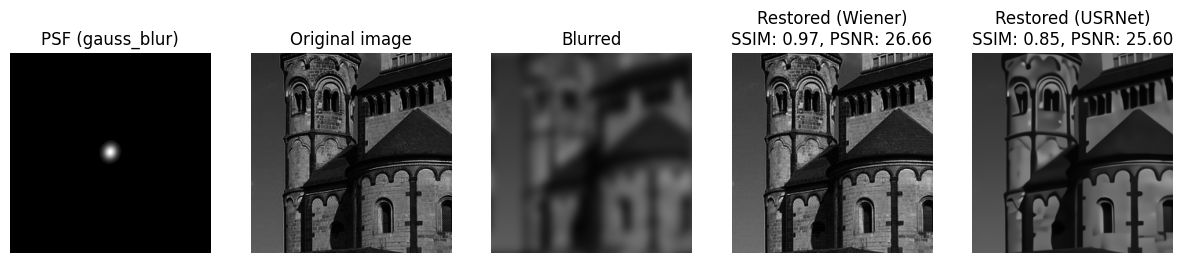

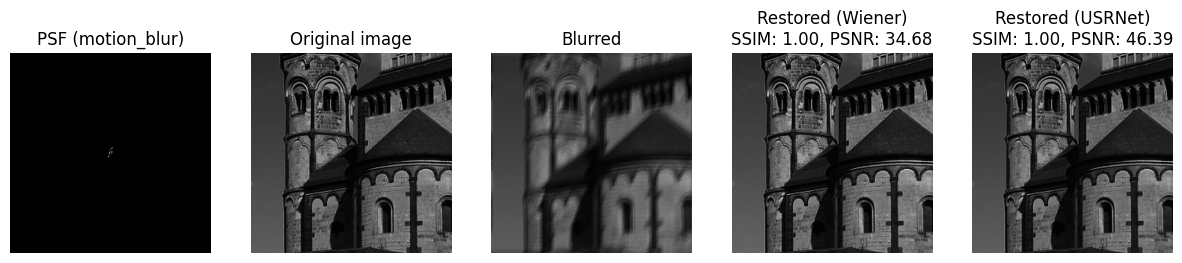

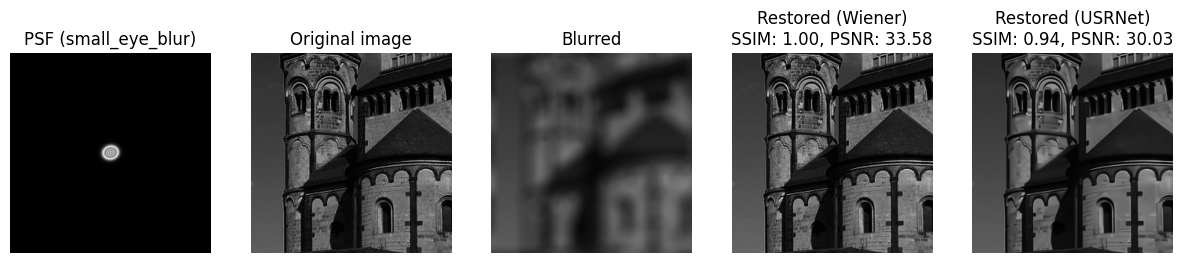

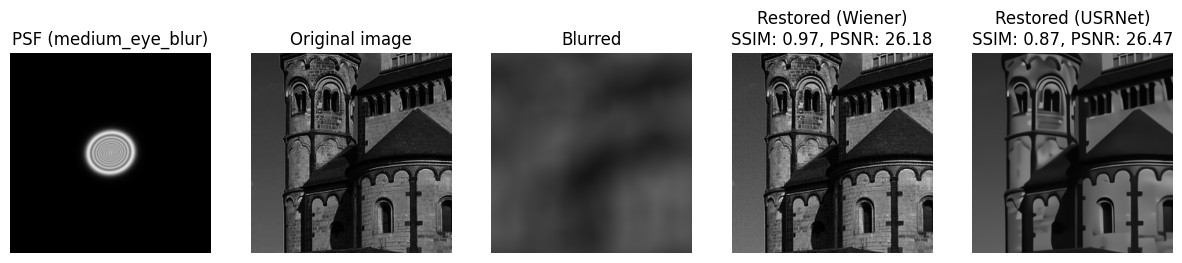

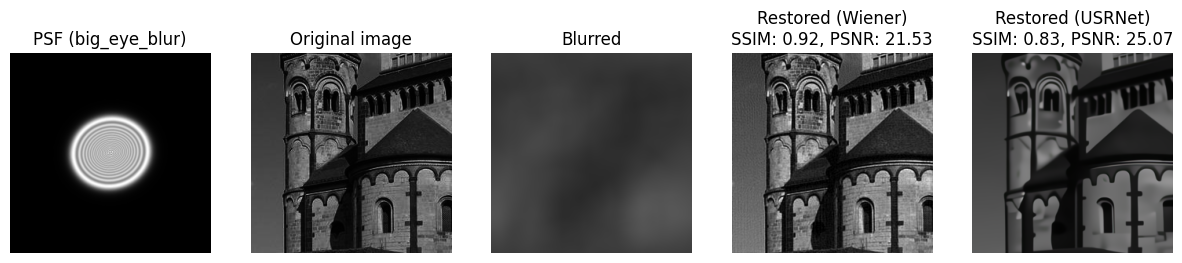

In [11]:
viz(
    image_path='../datasets/gt/Sun-gray/im_1.png',
    kernel_path='../datasets/kernels/gauss-blur/processed/synthetic/synthetic-17.npy',
    wiener=lambda image, psf: wiener_gray(image, psf, balance=1e-8, clip=True),
    usrnet=USRNetPredictor(model_path=cm.usrnet.model_path, **cm.usrnet.no_noise_params),
    blur_type='gauss_blur',
)

viz(
    image_path='../datasets/gt/Sun-gray/im_1.png',
    kernel_path='../datasets/kernels/motion-blur/processed/Levin/levin-0.npy',
    wiener=lambda image, psf: wiener_gray(image, psf, balance=1e-8, clip=True),
    usrnet=USRNetPredictor(model_path=cm.usrnet.model_path, **cm.usrnet.no_noise_params),
    blur_type='motion_blur',
)

viz(
    image_path='../datasets/gt/Sun-gray/im_1.png',
    kernel_path='../datasets/kernels/eye-psf/processed/synthetic/small-psf-0.npy',
    wiener=lambda image, psf: wiener_gray(image, psf, balance=1e-8, clip=True),
    usrnet=USRNetPredictor(model_path=cm.usrnet.model_path, **cm.usrnet.no_noise_params),
    blur_type='small_eye_blur',
)

viz(
    image_path='../datasets/gt/Sun-gray/im_1.png',
    kernel_path='../datasets/kernels/eye-psf/processed/synthetic/medium-psf-0.npy',
    wiener=lambda image, psf: wiener_gray(image, psf, balance=1e-8, clip=True),
    usrnet=USRNetPredictor(model_path=cm.usrnet.model_path, **cm.usrnet.no_noise_params),
    blur_type='medium_eye_blur',
)

viz(
    image_path='../datasets/gt/Sun-gray/im_1.png',
    kernel_path='../datasets/kernels/eye-psf/processed/synthetic/big-psf-0.npy',
    wiener=lambda image, psf: wiener_gray(image, psf, balance=1e-8, clip=True),
    usrnet=USRNetPredictor(model_path=cm.usrnet.model_path, **cm.usrnet.no_noise_params),
    blur_type='big_eye_blur',
)

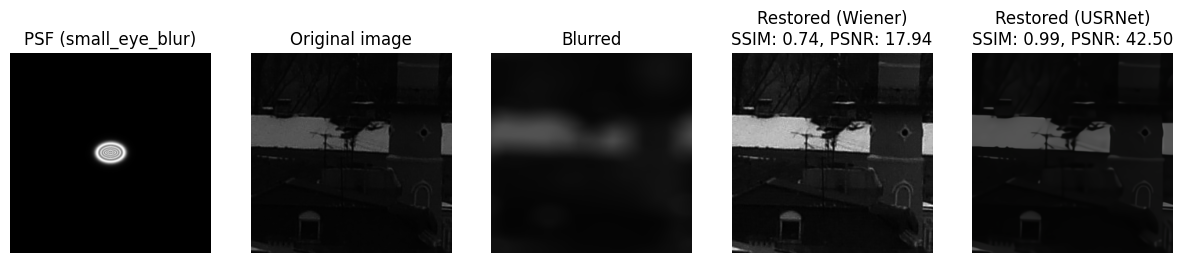

In [12]:
viz(
    image_path='../datasets/gt/precomp/city/01 (10).jpg',
    kernel_path='../datasets/kernels/eye-psf/processed/synthetic/small-psf-18.npy',
    wiener=lambda image, psf: wiener_gray(image, psf, balance=1e-8, clip=True),
    usrnet=USRNetPredictor(model_path=cm.usrnet.model_path, **cm.usrnet.no_noise_params),
    blur_type='small_eye_blur',
)